In [132]:
import pandas as pd

In [133]:
import ast


df = pd.read_csv("gemma_lobprob_benchmark_medmcqa_shuffled.csv")
df
list_from_string = ast.literal_eval(df['log_probs'][0])

list_from_string

[-1.2605003118515015,
 -0.043047644197940826,
 -0.0019704941660165787,
 -0.04186682775616646,
 -0.6131563186645508]

In [134]:
correct_answers_list = []
predicted_answer_list = []
logprob_list = []
linear_prob_list = []

def find_letter_in_list(lst):
    # Define the letters to search for
    letters_to_find = {'A', 'B', 'C', 'D', 'E'}
    
    # Loop through the list with index
    for index, value in enumerate(lst):
        # Check if the value (stripped of spaces) is one of the letters
        if value.strip() in letters_to_find:
            return value.strip(), index  # Return the found letter and its index
    
    # If no matching letter is found, return None
    return None, -1

for i, row in df.iterrows():
    # print(i)
    generation = ast.literal_eval(df['generated'][i])
    log_probs = ast.literal_eval(df['log_probs'][i]) 
    correct_answer = df['correct_answer'][i]
    linear_prob = ast.literal_eval(df['linear_probs'][i])

    predicted_answer = find_letter_in_list(generation)[0]
    if (predicted_answer == None):
        pass


    predicted_answer_list.append(predicted_answer)
    correct_answers_list.append(correct_answer)
    logprob_list.append(log_probs[find_letter_in_list(generation)[1]])
    linear_prob_list.append(linear_prob[find_letter_in_list(generation)[1]])

# print("hi")
new_df = pd.DataFrame({
    'correct_answer': correct_answers_list,
    'predicted_answer': predicted_answer_list,
    'logprob': logprob_list,
    'linear_prob': linear_prob_list
})

new_df = new_df[new_df['predicted_answer'].notna()]

new_df

,correct_answer,predicted_answer,logprob,linear_prob
0,A,A,-0.041867,95.899748
1,B,B,-0.023373,97.689851
2,B,D,-0.050992,95.028612
3,B,B,-0.011919,98.815210
4,B,D,-0.462193,62.990069
...,...,...,...,...
986,B,B,-0.091962,91.214013
989,A,A,-0.567467,56.695991
995,D,D,-0.170242,84.346061
997,B,B,-0.322660,72.422016


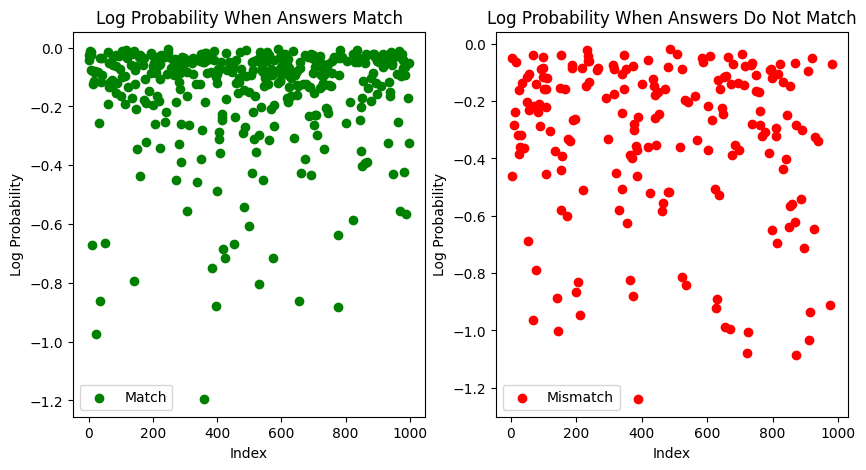

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming new_df is already created
# Filter where correct_answer and predicted_answer match
match_df = new_df[new_df['correct_answer'] == new_df['predicted_answer']]

# Filter where correct_answer and predicted_answer do not match
mismatch_df = new_df[new_df['correct_answer'] != new_df['predicted_answer']]

# Scatter plot for matches
plt.figure(figsize=(10, 5))

# Plot when answers match
plt.subplot(1, 2, 1)
plt.scatter(match_df.index, match_df['logprob'], color='green', label='Match')
plt.xlabel("Index")
plt.ylabel("Log Probability")
plt.title("Log Probability When Answers Match")
plt.legend()

# Plot when answers do not match
plt.subplot(1, 2, 2)
plt.scatter(mismatch_df.index, mismatch_df['logprob'], color='red', label='Mismatch')
plt.xlabel("Index")
plt.ylabel("Log Probability")
plt.title("Log Probability When Answers Do Not Match")
plt.legend()

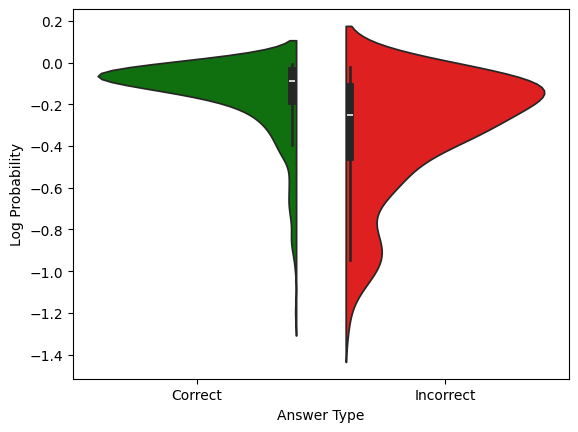

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

log_probs_correct = []
log_probs_incorrect = []

for i, row in new_df.iterrows():
    if row["correct_answer"] == row["predicted_answer"]:
        log_probs_correct.append(row["logprob"])
    else:
        log_probs_incorrect.append(row["logprob"])

# Prepare data in a DataFrame
data = pd.DataFrame({
    "Log Probability": log_probs_correct + log_probs_incorrect,
    "Answer Type": ["Correct"] * len(log_probs_correct) + ["Incorrect"] * len(log_probs_incorrect)
})

# Violin plot with overlapping distributions in different colors
sns.violinplot(x="Answer Type", y="Log Probability", data=data, split=True, hue="Answer Type", palette={"Correct": "green", "Incorrect": "red"})
plt.show()


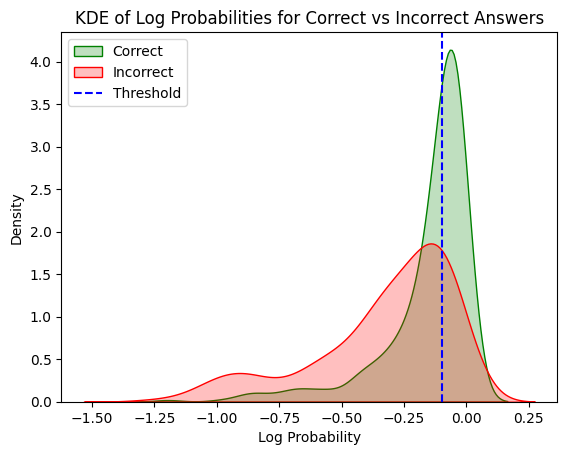

In [137]:
sns.kdeplot(log_probs_correct, label="Correct", color="green", fill=True)
sns.kdeplot(log_probs_incorrect, label="Incorrect", color="red", fill=True)

plt.xlabel("Log Probability")
plt.ylabel("Density")
plt.title("KDE of Log Probabilities for Correct vs Incorrect Answers")
plt.legend()

threshold_value = -0.1

# Optionally, mark a threshold line
plt.axvline(x=threshold_value, color="blue", linestyle="--", label="Threshold")
plt.legend()
plt.show()

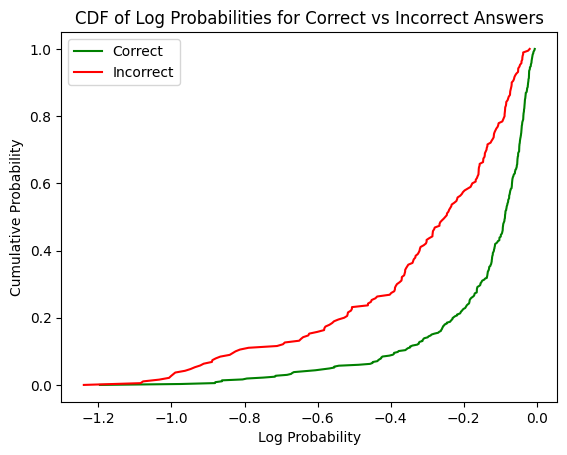

In [138]:
import numpy as np

# Sorting the data for cumulative distribution
sorted_correct = np.sort(log_probs_correct)
sorted_incorrect = np.sort(log_probs_incorrect)

# Plot CDF
plt.plot(sorted_correct, np.linspace(0, 1, len(sorted_correct)), label="Correct", color="green")
plt.plot(sorted_incorrect, np.linspace(0, 1, len(sorted_incorrect)), label="Incorrect", color="red")

plt.xlabel("Log Probability")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Log Probabilities for Correct vs Incorrect Answers")
plt.legend()
plt.show()


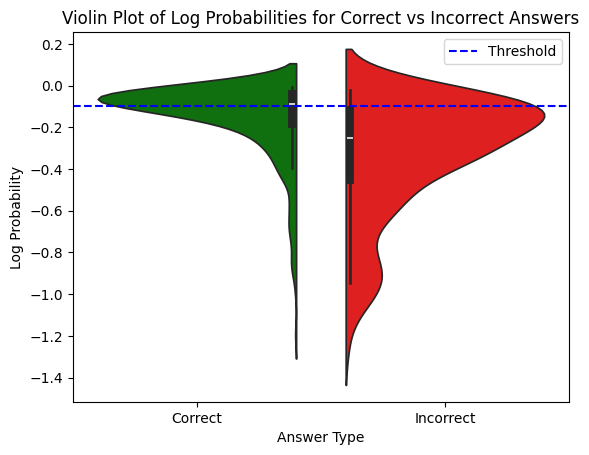

In [139]:
import pandas as pd

# Prepare data in a DataFrame
data = pd.DataFrame({
    "Log Probability": log_probs_correct + log_probs_incorrect,
    "Answer Type": ["Correct"] * len(log_probs_correct) + ["Incorrect"] * len(log_probs_incorrect)
})

sns.violinplot(x="Answer Type", y="Log Probability", data=data, split=True, hue="Answer Type", palette={"Correct": "green", "Incorrect": "red"})
plt.title("Violin Plot of Log Probabilities for Correct vs Incorrect Answers")
plt.axhline(y=threshold_value, color="blue", linestyle="--", label="Threshold")
plt.legend()
plt.show()


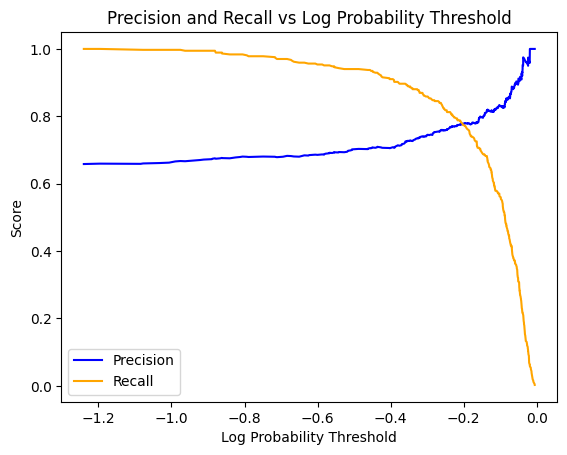

In [140]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Assume `new_df` contains columns "correct_answer", "predicted_answer", and "log_prob"
labels = []
log_probs_per_question = []

for i, row in new_df.iterrows():
    if row["correct_answer"] == row["predicted_answer"]:
        labels.append(1)
    else:
        labels.append(0)
    log_probs_per_question.append(row["logprob"])  # Append a single log prob per question

# Now labels and log_probs_per_question should have the same length
precision, recall, thresholds = precision_recall_curve(labels, log_probs_per_question)

# Plot precision and recall versus log probability thresholds
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="orange")
plt.xlabel("Log Probability Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Log Probability Threshold")
plt.legend()
plt.show()



Optimal Threshold: -0.44942671060562134
Maximum F1 Score: 0.8056206088992974
Optimal Threshold for Precision >= 90%: -0.005299567244946957


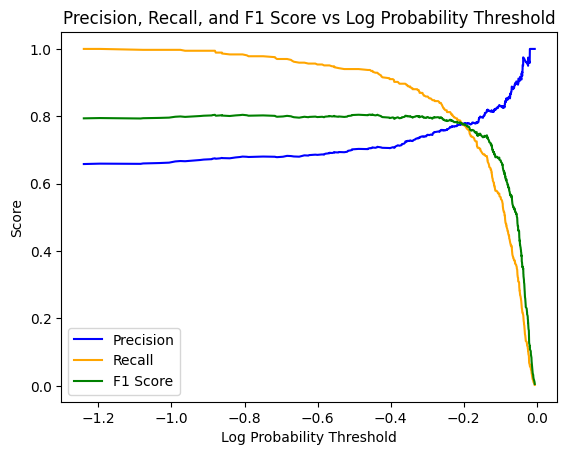

In [141]:
import numpy as np

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the index of the maximum F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Maximum F1 Score: {f1_scores[optimal_idx]}")

# Example: Find the highest threshold where precision is at least 90%
target_precision = 0.90
possible_thresholds = thresholds[precision[:-1] >= target_precision]

if possible_thresholds.size > 0:
    optimal_threshold = possible_thresholds[-1]  # Take the largest threshold meeting criteria
    print(f"Optimal Threshold for Precision >= 90%: {optimal_threshold}")
else:
    print("No threshold found with the specified precision.")

import matplotlib.pyplot as plt

# Plot precision, recall, and F1 score vs. threshold
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="orange")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="green")
plt.xlabel("Log Probability Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs Log Probability Threshold")
plt.legend()
plt.show()


In [142]:
# Calculate frequency of logprob > -0.1 for match_df
match_above_threshold = match_df[match_df['logprob'] > -0.1]
match_frequency = len(match_above_threshold) / len(match_df) if len(match_df) > 0 else 0

# Calculate frequency of logprob > -0.1 for mismatch_df
mismatch_above_threshold = mismatch_df[mismatch_df['logprob'] > -0.1]
mismatch_frequency = len(mismatch_above_threshold) / len(mismatch_df) if len(mismatch_df) > 0 else 0

# Display the frequencies and counts
print("Frequency of logprob > -0.1 when answers match:", match_frequency)
print("Count of logprob > -0.1 when answers match:", len(match_above_threshold))
print("Total correct answers: ", len(match_df))
print("Frequency of logprob > -0.1 when answers do not match:", mismatch_frequency)
print("Count of logprob > -0.1 when answers do not match:", len(mismatch_above_threshold))
print("Total wrong answers: ", len(mismatch_df))


Frequency of logprob > -0.1 when answers match: 0.5597826086956522
Count of logprob > -0.1 when answers match: 206
Total correct answers:  368
Frequency of logprob > -0.1 when answers do not match: 0.2198952879581152
Count of logprob > -0.1 when answers do not match: 42
Total wrong answers:  191


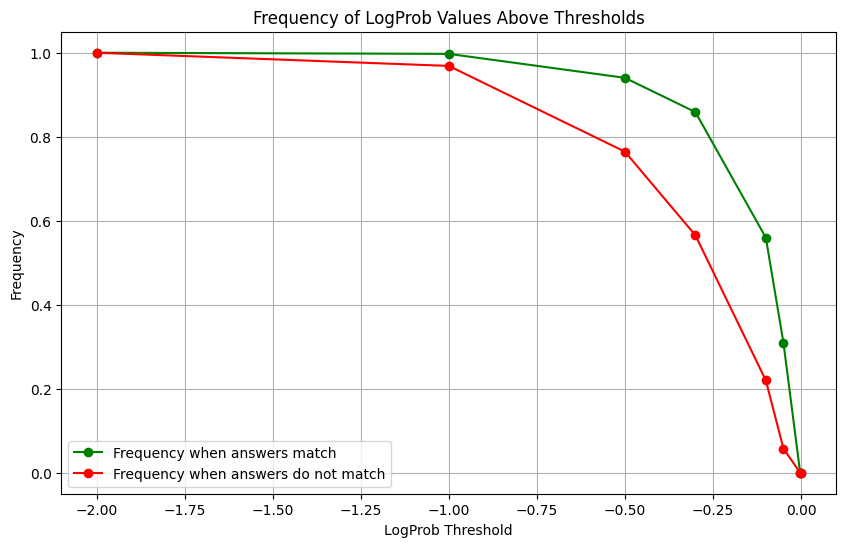

In [143]:
import matplotlib.pyplot as plt

# Define the thresholds you want to evaluate
thresholds = [-2, -1, -0.5, -0.3, -0.1, -0.05, -0.0025, 0.0]

# Initialize lists to store frequencies
match_frequencies = []
mismatch_frequencies = []

# Calculate frequencies for each threshold
for threshold in thresholds:
    # Frequency of logprob > threshold for match_df
    match_above_threshold = match_df[match_df['logprob'] > threshold]
    match_frequency = len(match_above_threshold) / len(match_df) if len(match_df) > 0 else 0
    match_frequencies.append(match_frequency)
    
    # Frequency of logprob > threshold for mismatch_df
    mismatch_above_threshold = mismatch_df[mismatch_df['logprob'] > threshold]
    mismatch_frequency = len(mismatch_above_threshold) / len(mismatch_df) if len(mismatch_df) > 0 else 0
    mismatch_frequencies.append(mismatch_frequency)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, match_frequencies, label='Frequency when answers match', marker='o', color='green')
plt.plot(thresholds, mismatch_frequencies, label='Frequency when answers do not match', marker='o', color='red')

# Adding titles and labels
plt.title("Frequency of LogProb Values Above Thresholds")
plt.xlabel("LogProb Threshold")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()